In [1]:
import torch, os, mlflow
import matplotlib.pyplot as plt
from mlflow_helper import load_attack_results
from mlflow.tracking.artifact_utils import get_artifact_uri

In [2]:
images, preds, clean_preds, labels = load_attack_results(1668278801, 'LinfProjectedGradientDescentAttack', 'images.pickle')
success = load_attack_results(1668278801, 'LinfProjectedGradientDescentAttack', 'success.pickle')
success_rate = load_attack_results(1668278801, 'LinfProjectedGradientDescentAttack', 'success_rate.pickle')
params = load_attack_results(1668278801, 'LinfProjectedGradientDescentAttack', 'params.pickle')

In [3]:
print(params, '\n')
print(images.size(), preds.size(), clean_preds.size(), labels.size(), success.size(), success_rate.size())

{'epsilons': [0, 0.1, 0.25, 0.5, 1, 3, 5, 7.5, 10], 'rel_stepsize': 0.03333333333333333, 'steps': 70, 'random_start': True, 'n_repeat': 3} 

torch.Size([9, 10000, 1, 60, 60]) torch.Size([9, 10000]) torch.Size([100]) torch.Size([100]) torch.Size([9, 10000]) torch.Size([9])


In [24]:
from data_loader import load_test_data
TEST_PATH = "s2_mnist_cs1.gz"
test_data = load_test_data(TEST_PATH)
unordered_labels = test_data[:][1]

In [28]:
ordered_labels = unordered_labels[unordered_labels == 0]
for i in range(1,10):
    ordered_labels = torch.cat((ordered_labels, unordered_labels[unordered_labels == i]))

In [50]:
torch.sum(ordered_labels == 0) + torch.sum(ordered_labels == 1) + torch.sum(ordered_labels == 2)

tensor(3147)

In [38]:
imgs = images[:,ordered_labels == 0][:,:10]
for i in range(1,10):
    imgs = torch.cat((imgs, images[:,ordered_labels == i][:,:10]), 1)
    
new_preds = preds[:,ordered_labels == 0][:,:10]
for i in range(1,10):
    new_preds = torch.cat((new_preds, preds[:,ordered_labels == i][:,:10]), 1)

In [62]:
torch.all(new_preds[0] == clean_preds)

tensor(True)

In [53]:
new_preds.size()

torch.Size([9, 100])

In [54]:
imgs.size()

torch.Size([9, 100, 1, 60, 60])

In [63]:
from attack_helper import save_pickle

In [72]:
def repair_images_pickle(run_name: int, ordered_labels):
    images, preds, clean_preds, labels = load_attack_results(run_name, 'LinfProjectedGradientDescentAttack', 'images.pickle')
    imgs = images[:,ordered_labels == 0][:,:10]
    for i in range(1,10):
        imgs = torch.cat((imgs, images[:,ordered_labels == i][:,:10]), 1)

    new_preds = preds[:,ordered_labels == 0][:,:10]
    for i in range(1,10):
        new_preds = torch.cat((new_preds, preds[:,ordered_labels == i][:,:10]), 1)
        
    tracking_uri = 'sqlite:///mlruns/database.db'
    mlflow.set_tracking_uri(tracking_uri)
    df=mlflow.search_runs(experiment_names=['model_training'])
    run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
    artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
    attack_path = os.path.join(artifact_path, 'LinfProjectedGradientDescentAttack')
        
    save_pickle(attack_path, 'images_.pickle', [imgs, new_preds, clean_preds, labels])

In [73]:
repair_images_pickle(1668278801, ordered_labels)

In [74]:
data = load_attack_results(1668278801, 'LinfProjectedGradientDescentAttack', 'images_.pickle')

In [78]:
print(torch.all(data[0] == imgs))
print(torch.all(data[1] == new_preds))
print(torch.all(data[2] == clean_preds))
print(torch.all(data[3] == labels))

tensor(True)
tensor(True)
tensor(True)
tensor(True)


In [92]:
run_names = [1667820145, 1667706428, 1667745011, 1667634222, 1667729890, 1667599289]

In [94]:
for run_name in run_names:
    repair_images_pickle(run_name, ordered_labels)

In [95]:
data1 = load_attack_results(1667820145, 'LinfProjectedGradientDescentAttack', 'images.pickle')
data2 = load_attack_results(1667820145, 'LinfProjectedGradientDescentAttack', 'images_.pickle')

In [99]:
print(torch.all(data1[2] == data2[2]))
print(torch.all(data1[3] == data2[3]))
print(torch.all(data1[0][0,9] == data2[0][0,9]))

tensor(True)
tensor(True)
tensor(True)


In [2]:
def print_run_id(run_name: int):
    tracking_uri = 'sqlite:///mlruns/database.db'
    mlflow.set_tracking_uri(tracking_uri)
    df=mlflow.search_runs(experiment_names=['model_training'])
    run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
    print(run_id)

In [90]:
print_run_id(1668278801)

362c8650f8454cde82f761119d6531f7


In [3]:
run_names = [1668278801, 1668279489, 1668283177, 1668284221, 1668289478, 1668296690, 1668302862, 1668309303,
             1668319357, 1668343081, 1668361949, 1667820145, 1667706428, 1667745011, 1667634222, 1667729890,
             1667599289, 1668278459]

In [5]:
for run_name in run_names[10:]:
    print_run_id(run_name)

5f9dda562bd34637a8a4ff6db5770286
dd952dc386a34a6290d418170258349e
bff70b5e50ec4661bc929dc274a26411
411f23ecabe74b3494c420de2b3b53a5
15c0997bd5d341ba92f86667ba2e6b11
498967f492fd4727894cac99f40905c8
23988a222ad24ccfa0ba37662ee433b4
6e76d564a6304b77843bcb8c2475e5b2


In [ ]:
mv LinfProjectedGradientDescentAttack LinfProjectedGradientDescentAttack_no_logits

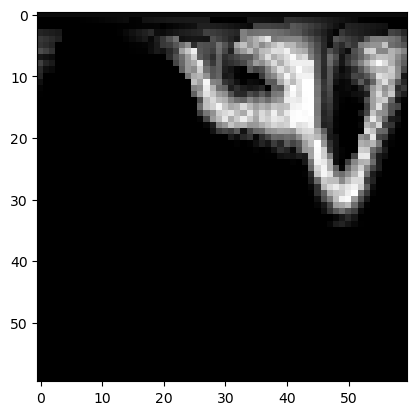

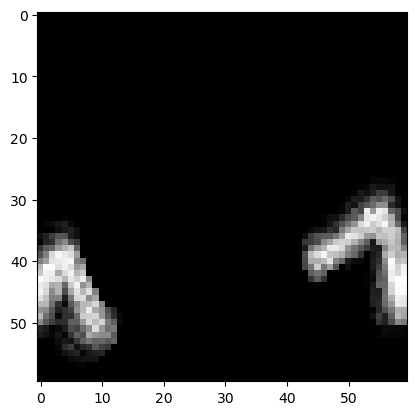

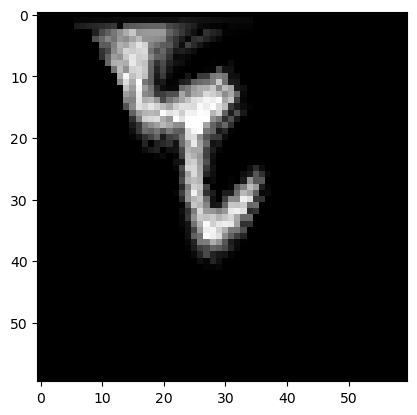

In [49]:
for i in range(30, 33):
    plt.imshow(imgs[0,i,0], cmap='gray')
    plt.show()

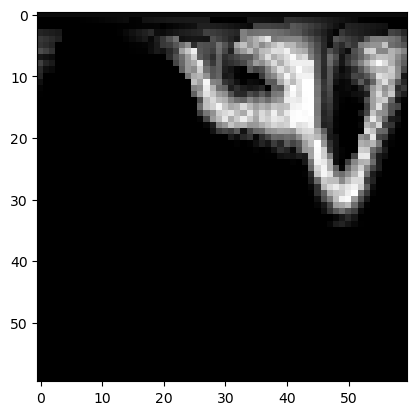

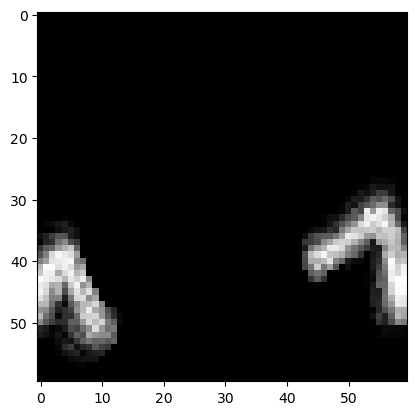

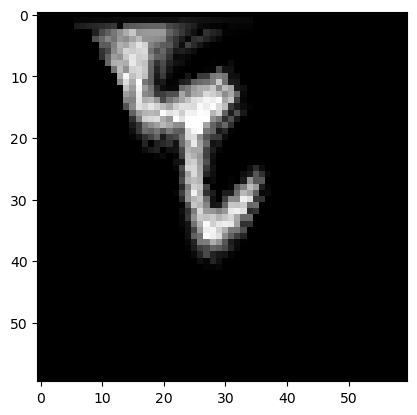

In [51]:
for i in range(3147, 3150):
    plt.imshow(images[0,i,0], cmap='gray')
    plt.show()

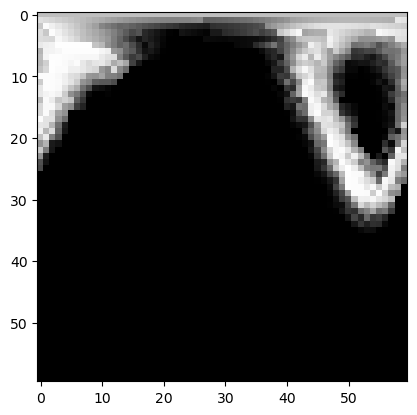

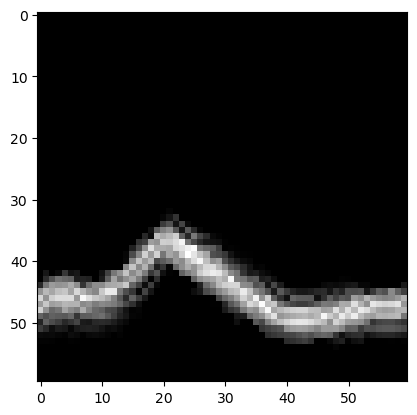

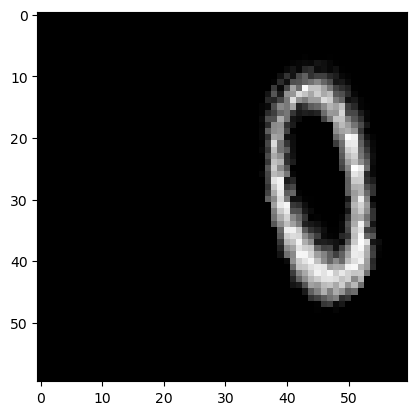

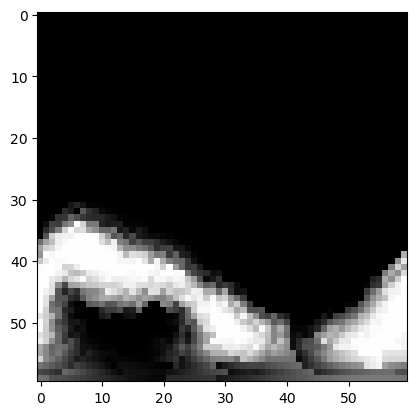

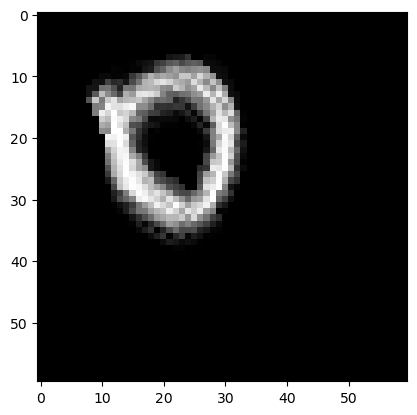

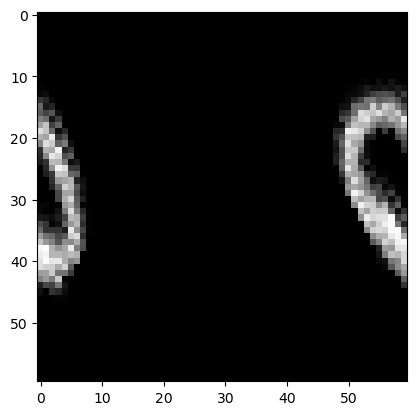

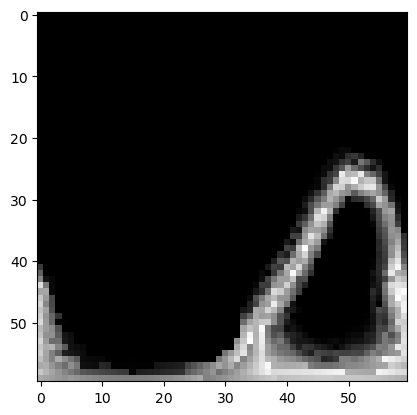

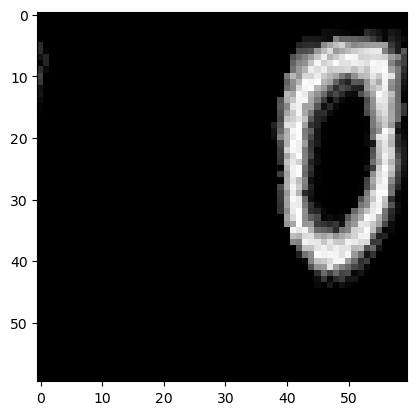

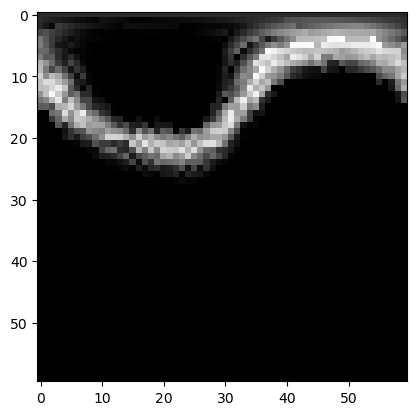

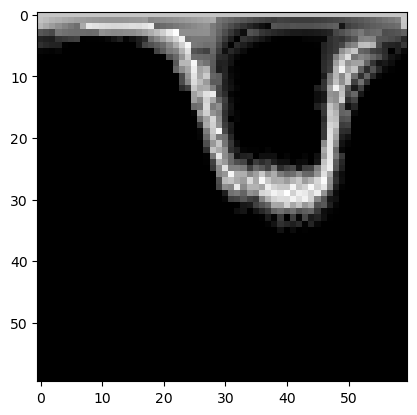

In [9]:
for i in range(10):
    plt.imshow(images[0,i,0], cmap='gray')
    plt.show()

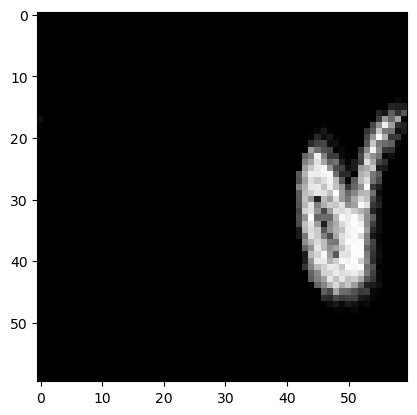

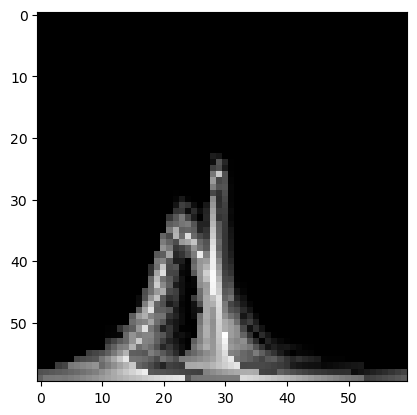

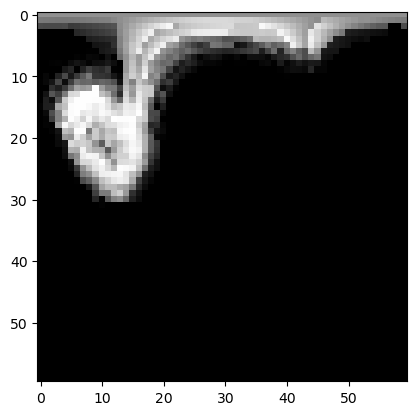

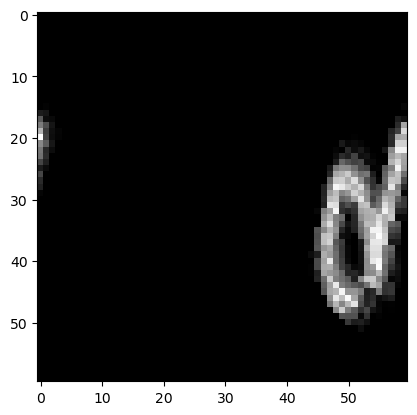

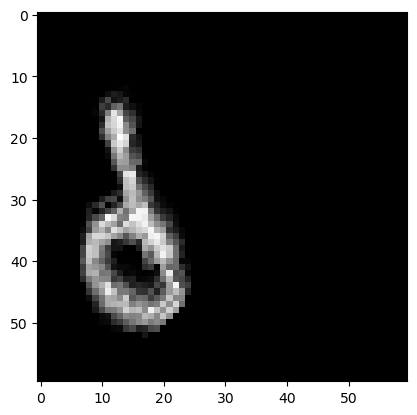

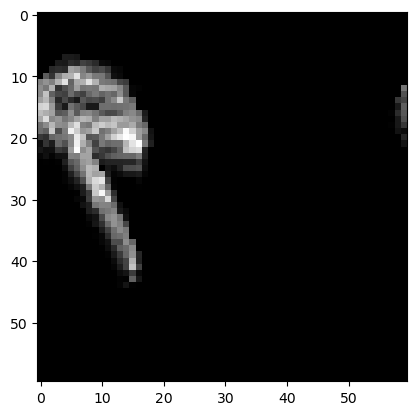

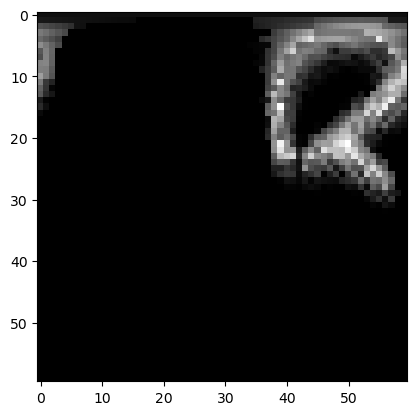

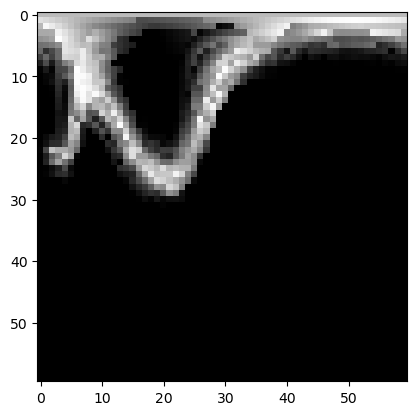

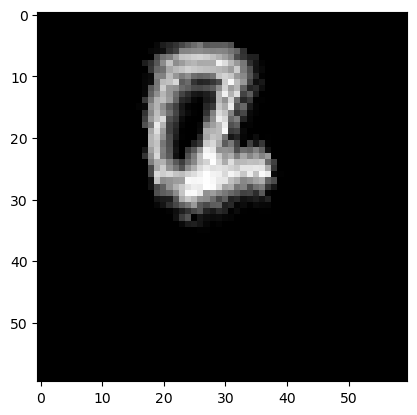

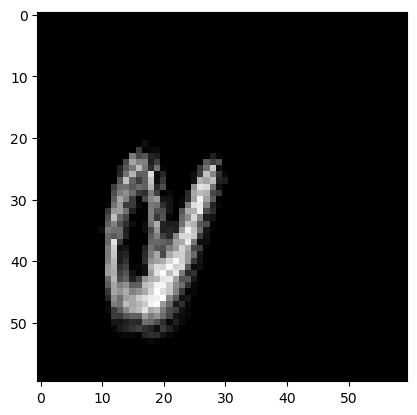

In [21]:
for i in range(9500,9510):
    plt.imshow(images[0,i,0], cmap='gray')
    plt.show()